In [52]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb  3 08:29:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    40W / 250W |   2641MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [53]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.77 s (started: 2022-02-03 08:29:25 +00:00)


In [54]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 795 µs (started: 2022-02-03 08:29:29 +00:00)


In [55]:
# AUTOGLUON cf https://ichi.pro/fr/premiers-pas-avec-automl-et-aws-autogluon-118506426920853
# Here we assume CUDA 10.0 is installed.  You should change the number
# according to your own CUDA version (e.g. mxnet-cu101 for CUDA 10.1).
!pip install --upgrade mxnet-cu100
!pip install autogluon

time: 16.6 s (started: 2022-02-03 08:29:29 +00:00)


In [56]:
!pip install -U ipykernel

time: 6.18 s (started: 2022-02-03 08:29:45 +00:00)


# RESTART RUNTIME 

In [57]:
import autogluon as ag
from autogluon.vision import ImagePredictor, ImageDataset

time: 1.1 ms (started: 2022-02-03 08:29:52 +00:00)


In [58]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.layer_utils import count_params


time: 22.9 ms (started: 2022-02-03 08:29:52 +00:00)


# Variables

## Paths

In [59]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220203_08H29/
time: 11.6 ms (started: 2022-02-03 08:29:52 +00:00)


## Other

In [60]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = None # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 10
# learing rate 
# learning_rate = 0.001 # a learning rate of 0.001 is often used / working
# batch size 
batch_size = 32 #32
# base model trainable 
base_model_trainable = False

# number of trials optuna
n_trials = 25 

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 4.22 ms (started: 2022-02-03 08:29:52 +00:00)


# Load & filter data

## Unzip images

In [61]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 2.02 ms (started: 2022-02-03 08:29:52 +00:00)


In [62]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 2.3 ms (started: 2022-02-03 08:29:52 +00:00)


## File_path df

In [63]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


215410 rows in the file


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 2.43 s (started: 2022-02-03 08:29:52 +00:00)


In [64]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 1.19 ms (started: 2022-02-03 08:29:54 +00:00)


In [65]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 336 ms (started: 2022-02-03 08:29:54 +00:00)


In [66]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 188 ms (started: 2022-02-03 08:29:55 +00:00)


In [67]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 77.7 ms (started: 2022-02-03 08:29:55 +00:00)


In [68]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 123 ms (started: 2022-02-03 08:29:55 +00:00)


In [69]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 108 ms (started: 2022-02-03 08:29:55 +00:00)


In [70]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 38.3 ms (started: 2022-02-03 08:29:55 +00:00)


In [71]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 53 ms (started: 2022-02-03 08:29:55 +00:00)


In [72]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 1.38 ms (started: 2022-02-03 08:29:55 +00:00)


In [73]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

time: 2.81 ms (started: 2022-02-03 08:29:55 +00:00)


In [74]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 14 ms (started: 2022-02-03 08:29:55 +00:00)


In [75]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
5,/content/RAW DATA/IMAGES/2006/Agaricus/682.jpg,Agaricaceae,0
6,/content/RAW DATA/IMAGES/2006/Agaricus/685.jpg,Agaricaceae,0
7,/content/RAW DATA/IMAGES/2006/Agaricus albolut...,Agaricaceae,0
8,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0
9,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0


time: 68.4 ms (started: 2022-02-03 08:29:55 +00:00)


In [76]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.08 ms (started: 2022-02-03 08:29:55 +00:00)


In [77]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 35787


,label,gbif_info.family,size
0,0,Agaricaceae,5254
1,1,Strophariaceae,4494
2,2,Amanitaceae,4769
3,3,Boletaceae,6060
4,4,Tricholomataceae,4967
5,5,Cortinariaceae,4124
6,6,Russulaceae,6119


time: 24.6 ms (started: 2022-02-03 08:29:55 +00:00)


In [78]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

time: 6.45 ms (started: 2022-02-03 08:29:55 +00:00)


## Train/test split

In [79]:
#train/test 
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
print(df_train.shape,df_test.shape)

(28629, 3) (7158, 3)
time: 54.6 ms (started: 2022-02-03 08:29:55 +00:00)


In [80]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 38.6 ms (started: 2022-02-03 08:29:56 +00:00)


### Plot few images

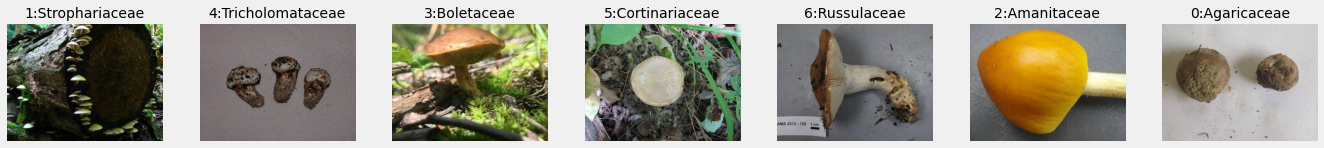

time: 534 ms (started: 2022-02-03 08:29:56 +00:00)


In [81]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

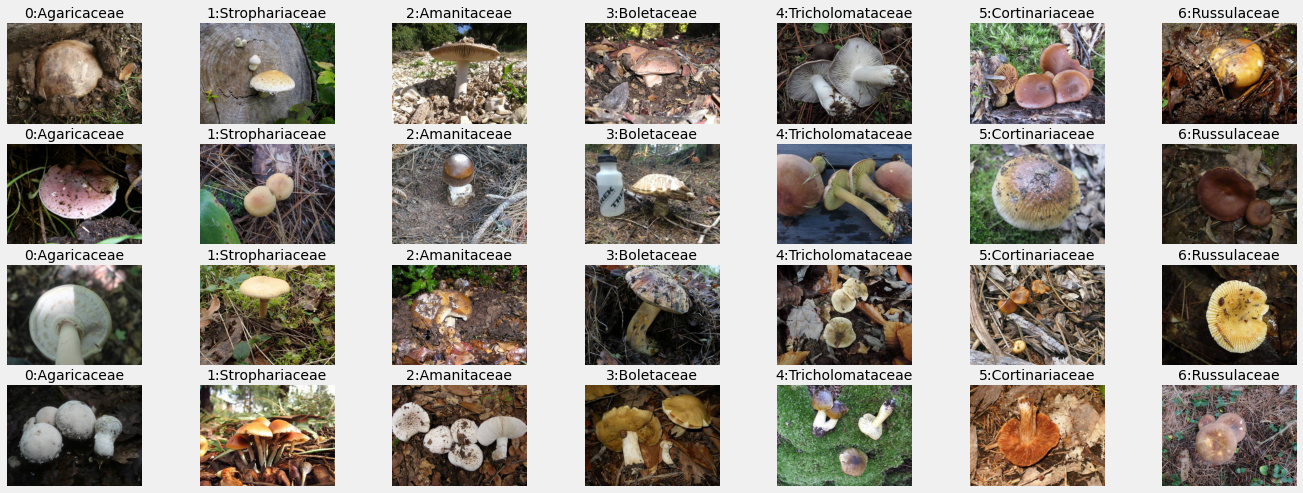

time: 2.66 s (started: 2022-02-03 08:29:56 +00:00)


In [82]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Autogluon

## Create datasets

In [83]:
# Load train dataset 
df_train_ag = df_train.copy()
df_train_ag ['image'] = df_train_ag ['drive_file_path'] #add image col with path 
df_train_ag .to_csv('train_csv')
train_dataset = ImageDataset.from_csv('/content/train_csv')
train_dataset 

,Unnamed: 0,drive_file_path,gbif_info.family,label,image
0,9168,/content/RAW DATA/IMAGES/2008/Hypholoma capnoi...,Strophariaceae,1,/content/RAW DATA/IMAGES/2008/Hypholoma capnoi...
1,1259,/content/RAW DATA/IMAGES/2006/Tricholoma murri...,Tricholomataceae,4,/content/RAW DATA/IMAGES/2006/Tricholoma murri...
2,214927,/content/RAW DATA/IMAGES/2016/Xerocomus/632521...,Boletaceae,3,/content/RAW DATA/IMAGES/2016/Xerocomus/632521...
3,135161,/content/RAW DATA/IMAGES/2014/Cortinarius/4604...,Cortinariaceae,5,/content/RAW DATA/IMAGES/2014/Cortinarius/4604...
4,153742,/content/RAW DATA/IMAGES/2014/Russula pectinat...,Russulaceae,6,/content/RAW DATA/IMAGES/2014/Russula pectinat...
...,...,...,...,...,...
28624,17186,/content/RAW DATA/IMAGES/2009/Clitocybe nuda/7...,Tricholomataceae,4,/content/RAW DATA/IMAGES/2009/Clitocybe nuda/7...
28625,90199,/content/RAW DATA/IMAGES/2012/Pholiota/290846.jpg,Strophariaceae,1,/content/RAW DATA/IMAGES/2012/Pholiota/290846.jpg
28626,184155,/content/RAW DATA/IMAGES/2015/Tricholoma sapon...,Tricholomataceae,4,/content/RAW DATA/IMAGES/2015/Tricholoma sapon...
28627,143635,/content/RAW DATA/IMAGES/2014/Lactarius oculat...,Russulaceae,6,/content/RAW DATA/IMAGES/2014/Lactarius oculat...


time: 715 ms (started: 2022-02-03 08:29:59 +00:00)


In [84]:
# Load test dataset 
df_test_ag = df_test.copy()
df_test_ag ['image'] = df_test_ag ['drive_file_path'] #add image col with path 
df_test_ag .to_csv('test_csv')
test_dataset = ImageDataset.from_csv('/content/test_csv')
test_dataset 

,Unnamed: 0,drive_file_path,gbif_info.family,label,image
0,26647,/content/RAW DATA/IMAGES/2009/Tricholoma/54250...,Tricholomataceae,4,/content/RAW DATA/IMAGES/2009/Tricholoma/54250...
1,37124,/content/RAW DATA/IMAGES/2010/Infundibulicybe ...,Tricholomataceae,4,/content/RAW DATA/IMAGES/2010/Infundibulicybe ...
2,197994,/content/RAW DATA/IMAGES/2016/Gymnopilus/64321...,Strophariaceae,1,/content/RAW DATA/IMAGES/2016/Gymnopilus/64321...
3,25223,/content/RAW DATA/IMAGES/2009/Russula/46954.jpg,Russulaceae,6,/content/RAW DATA/IMAGES/2009/Russula/46954.jpg
4,103277,/content/RAW DATA/IMAGES/2013/Boletus edulis/3...,Boletaceae,3,/content/RAW DATA/IMAGES/2013/Boletus edulis/3...
...,...,...,...,...,...
7153,2761,/content/RAW DATA/IMAGES/2007/Handkea utriform...,Agaricaceae,0,/content/RAW DATA/IMAGES/2007/Handkea utriform...
7154,114483,/content/RAW DATA/IMAGES/2013/Lactarius thyino...,Russulaceae,6,/content/RAW DATA/IMAGES/2013/Lactarius thyino...
7155,94148,/content/RAW DATA/IMAGES/2012/Russula/249488.jpg,Russulaceae,6,/content/RAW DATA/IMAGES/2012/Russula/249488.jpg
7156,129362,/content/RAW DATA/IMAGES/2014/Amanita gemmata/...,Amanitaceae,2,/content/RAW DATA/IMAGES/2014/Amanita gemmata/...


time: 192 ms (started: 2022-02-03 08:30:00 +00:00)


## Fit 

ImagePredictor sets accuracy as default eval_metric for classification problems.
Presets specified: ['best_quality']
Randomly split train_data into train[25766]/validation[2863] splits.
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Starting HPO experiments
modified configs(<old> != <new>): {
root.img_cls.model   resnet101 != coat_lite_small
root.train.lr        0.01 != 0.0003162278
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 8
root.train.early_stop_patience -1 != 50
root.train.early_stop_max_value 1.0 != inf
root.misc.seed       42 != 179
root.misc.num_workers 4 != 2
}
Saved config to /content/ae1a4705/.trial_0/config.yaml
Model coat_lite_small created, param count:                                         19329095
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 24.374966 samples/sec	accuracy=0.157500	lr=0.000100
Epoch[0

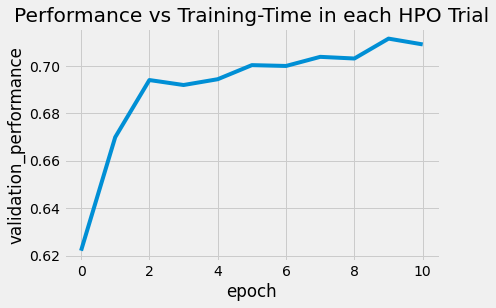

Finished, total runtime is 7363.97 s
{ 'best_config': { 'augmentation': { 'auto_augment': None,
                                     'color_jitter': 0.4,
                                     'cutmix': 0.0,
                                     'cutmix_minmax': None,
                                     'drop': 0.0,
                                     'drop_block': None,
                                     'drop_path': None,
                                     'hflip': 0.5,
                                     'mixup': 0.0,
                                     'mixup_mode': 'batch',
                                     'mixup_off_epoch': 0,
                                     'mixup_prob': 1.0,
                                     'mixup_switch_prob': 0.5,
                                     'no_aug': False,
                                     'ratio': (0.75, 1.3333333333333333),
                                     'scale': (0.08, 1.0),
                                     'smooth

time: 2h 2min 44s (started: 2022-02-03 08:30:00 +00:00)


In [85]:
predictor = ImagePredictor()
# since the original dataset does not provide validation split, the `fit` function splits it randomly with 90/10 ratio
predictor.fit(train_dataset,
              time_limit=60*60*2, 
              presets='best_quality')  # you can trust the default config, we reduce the # epoch to save some build time

In [92]:
filename = export_dir + 'predictor.ag'
predictor.save(filename)

time: 1.58 s (started: 2022-02-03 10:57:47 +00:00)


# Assess + conf matrix

In [ ]:
# load model 
predictor = ImagePredictor.load('/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220203_08H29/'+ 'predictor.ag')

In [86]:
test_acc = predictor.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc['top1'])

[Epoch 9] validation: top1=0.703129 top5=0.985191


Top-1 test acc: 0.703
time: 1min 7s (started: 2022-02-03 10:32:45 +00:00)


In [87]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  'Autogluon 7 familles' + '\n Train=' + str(len(df_train)) + ' images / Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 2.21 ms (started: 2022-02-03 10:33:52 +00:00)


##  Plots

In [116]:
test_pred_class = []
for i in tqdm(range(len(test_dataset))):
  image_path = test_dataset.iloc[i]['image']
  result = predictor.predict(image_path)[0]
  test_pred_class.append(result)

100%|██████████| 7158/7158 [1:05:31<00:00,  1.82it/s]

time: 1h 5min 31s (started: 2022-02-03 12:04:39 +00:00)


In [113]:
# image_path = test_dataset.iloc[5]['image']
# result = predictor.predict(image_path)[0]


numpy.int64

time: 797 ms (started: 2022-02-03 12:03:15 +00:00)


In [107]:
test_pred_class2 = predictor.predict(test_dataset)

time: 1min 8s (started: 2022-02-03 11:55:41 +00:00)


In [119]:
(test_pred_class == test_pred_class2).sum() 

3191

time: 16 ms (started: 2022-02-03 13:10:46 +00:00)


In [120]:
test_dataset

,Unnamed: 0,drive_file_path,gbif_info.family,label,image
0,26647,/content/RAW DATA/IMAGES/2009/Tricholoma/54250...,Tricholomataceae,4,/content/RAW DATA/IMAGES/2009/Tricholoma/54250...
1,37124,/content/RAW DATA/IMAGES/2010/Infundibulicybe ...,Tricholomataceae,4,/content/RAW DATA/IMAGES/2010/Infundibulicybe ...
2,197994,/content/RAW DATA/IMAGES/2016/Gymnopilus/64321...,Strophariaceae,1,/content/RAW DATA/IMAGES/2016/Gymnopilus/64321...
3,25223,/content/RAW DATA/IMAGES/2009/Russula/46954.jpg,Russulaceae,6,/content/RAW DATA/IMAGES/2009/Russula/46954.jpg
4,103277,/content/RAW DATA/IMAGES/2013/Boletus edulis/3...,Boletaceae,3,/content/RAW DATA/IMAGES/2013/Boletus edulis/3...
...,...,...,...,...,...
7153,2761,/content/RAW DATA/IMAGES/2007/Handkea utriform...,Agaricaceae,0,/content/RAW DATA/IMAGES/2007/Handkea utriform...
7154,114483,/content/RAW DATA/IMAGES/2013/Lactarius thyino...,Russulaceae,6,/content/RAW DATA/IMAGES/2013/Lactarius thyino...
7155,94148,/content/RAW DATA/IMAGES/2012/Russula/249488.jpg,Russulaceae,6,/content/RAW DATA/IMAGES/2012/Russula/249488.jpg
7156,129362,/content/RAW DATA/IMAGES/2014/Amanita gemmata/...,Amanitaceae,2,/content/RAW DATA/IMAGES/2014/Amanita gemmata/...


time: 32.8 ms (started: 2022-02-03 13:11:12 +00:00)


In [121]:
y_test_class = test_dataset['label']

time: 945 µs (started: 2022-02-03 13:11:16 +00:00)


In [123]:
# # predict y_test
# test_pred_class = predictor.predict(test_dataset)
# y_test_class= test_dataset['label']
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir  + '_classification report.csv'
report.to_csv(report_path)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1051
           1       0.63      0.63      0.63       899
           2       0.78      0.78      0.78       954
           3       0.82      0.87      0.84      1212
           4       0.64      0.54      0.59       993
           5       0.60      0.57      0.58       825
           6       0.70      0.77      0.74      1224

    accuracy                           0.70      7158
   macro avg       0.69      0.69      0.69      7158
weighted avg       0.70      0.70      0.70      7158

time: 223 ms (started: 2022-02-03 13:12:53 +00:00)


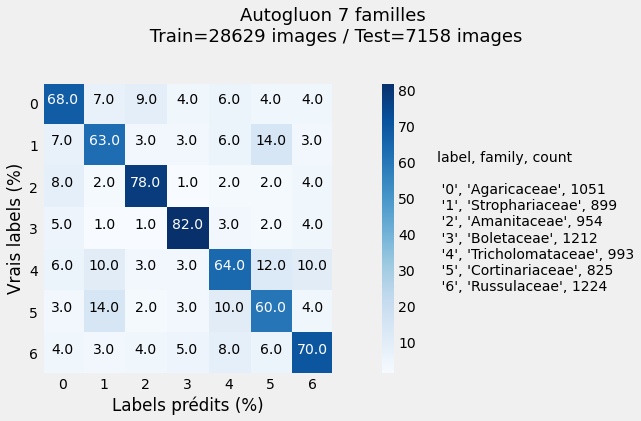

time: 861 ms (started: 2022-02-03 13:12:57 +00:00)


In [124]:
# conf matrix  
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir  +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')

In [125]:
test_acc = predictor.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc['top1'])

[Epoch 9] validation: top1=0.703129 top5=0.985191


Top-1 test acc: 0.703
time: 1min 7s (started: 2022-02-03 13:13:36 +00:00)


In [95]:
export_dir

'/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220203_08H29/'

time: 5.23 ms (started: 2022-02-03 10:58:55 +00:00)


In [ ]:
# !kill -9 -1